# Load data and model

In [1]:
import torch
torch.set_printoptions(precision=1, sci_mode=False)
device = 'cuda'

In [2]:
run_name = 'pubchem16_dev'

In [3]:
from GRALE.main import GRALE_model
import torch
# Load a Lightning checkpoint
checkpoint_path = f"checkpoints/{run_name}/last.ckpt"
model = GRALE_model.load_from_checkpoint(checkpoint_path)
config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)["hyper_parameters"]

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Load data
from GRALE.data.dataset import DataModule

path_h5 = 'data/h5/PUBCHEM_16.h5'
datamodule = DataModule(
    path_h5=path_h5,
    batch_size=16,
    n_data_epoch=10000,
    n_data_valid=10000
)

---
The full train dataset is of size 13790234.
Every epoch a chunk of size 10000 is loaded.
The entire dataset will be iterated every 1380 epochs.
Consider increasing n_data_epoch for better efficiency.
---
Loading only 10000 samples of the valid dataset in memory.
---


# Plot Reconstruction (Networkx)

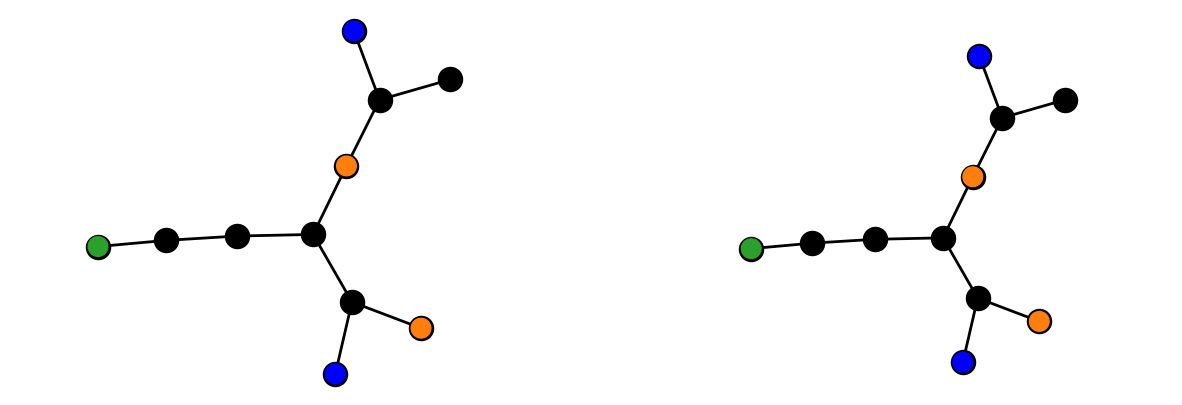

In [ ]:
import matplotlib.pyplot as plt
from GRALE.vizualization.plots import plot_graph, atomic_num_colormap

node_size = 200
frame = False
edge_weight = True
hard_permuter = True

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:]
        node_labels_preds = outputs.nodes.labels[k][:size,:]
        A_inputs = inputs.edges.adjacency[k][:size,:size]
        A_preds = outputs.edges.adjacency[k][:size,:size]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        pos = 'kamada'
        pos = plot_graph(node_labels_inputs,A_inputs,ax=ax1,pos=pos,frame=frame,edge_weight=edge_weight)
        plot_graph(node_labels_preds,A_preds,ax=ax2,pos=pos,frame=frame,edge_weight=edge_weight)
        plt.show()
        break
    break

# Plot Reconstructions (Rdkit)

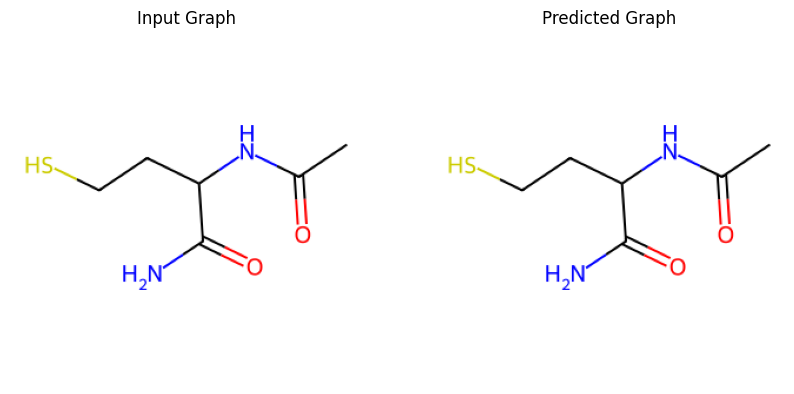

[12:00:49] Explicit valence for atom # 6 N, 4, is greater than permitted


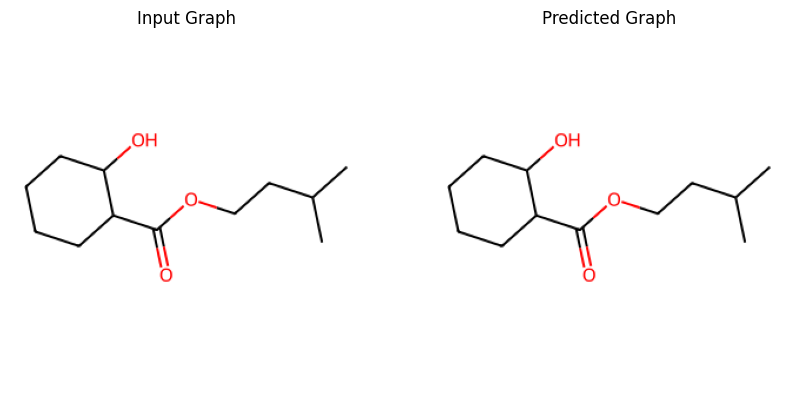

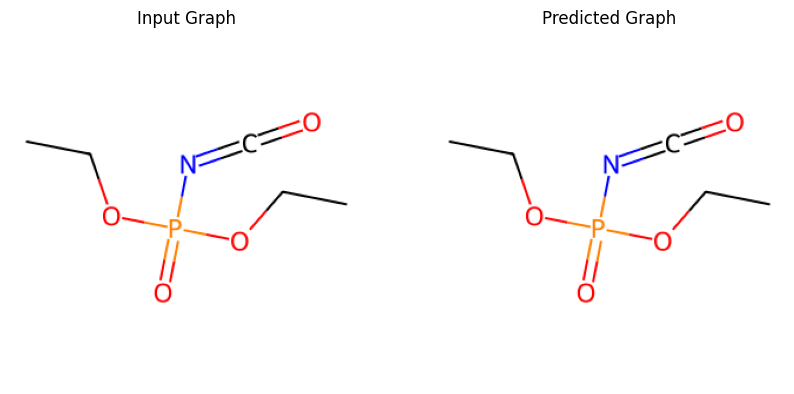

[12:00:49] Explicit valence for atom # 5 N, 6, is greater than permitted


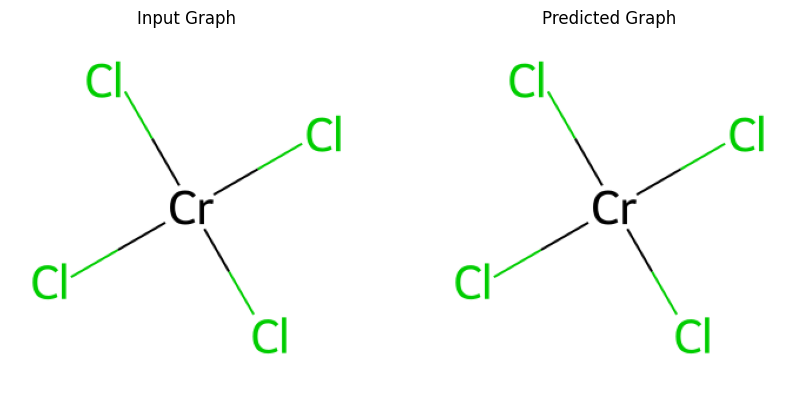

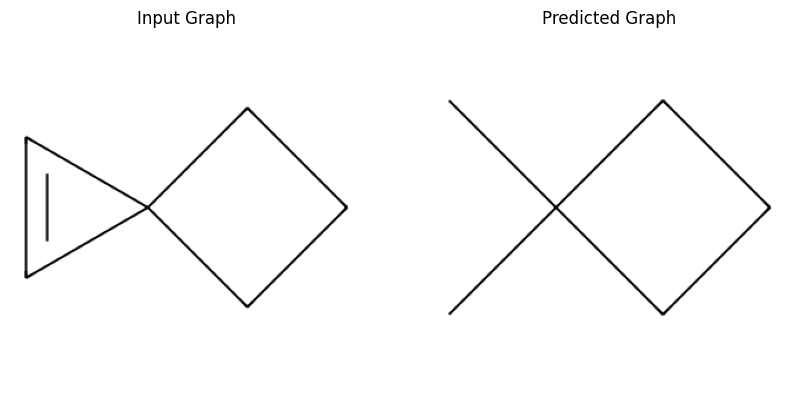

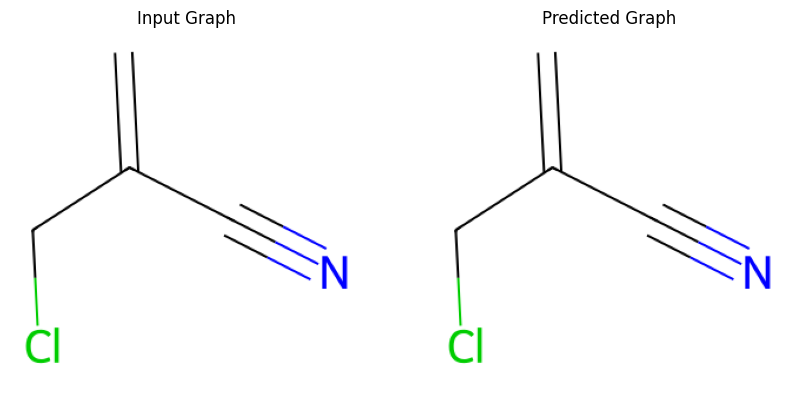

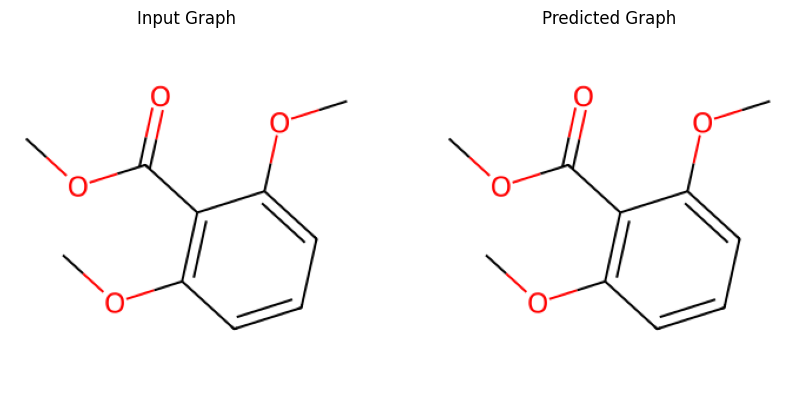

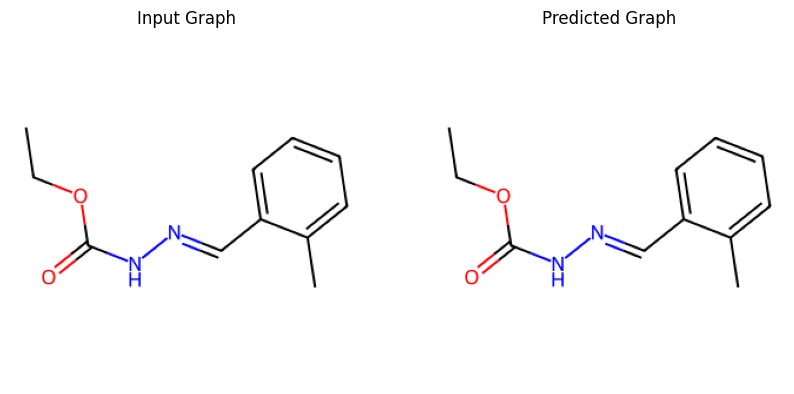

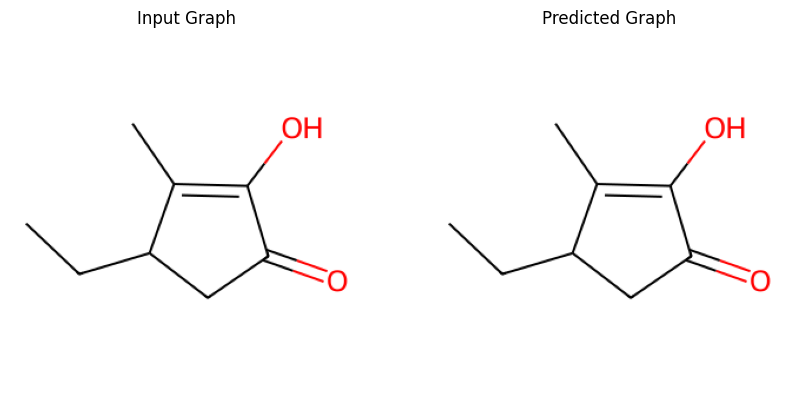

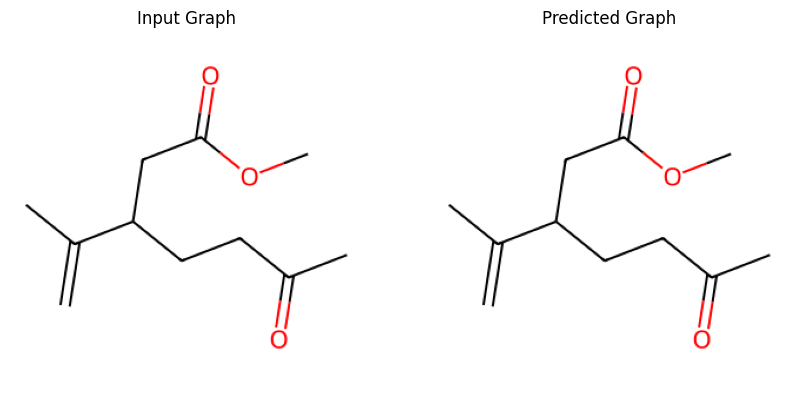

[12:00:50] Explicit valence for atom # 7 C, 5, is greater than permitted


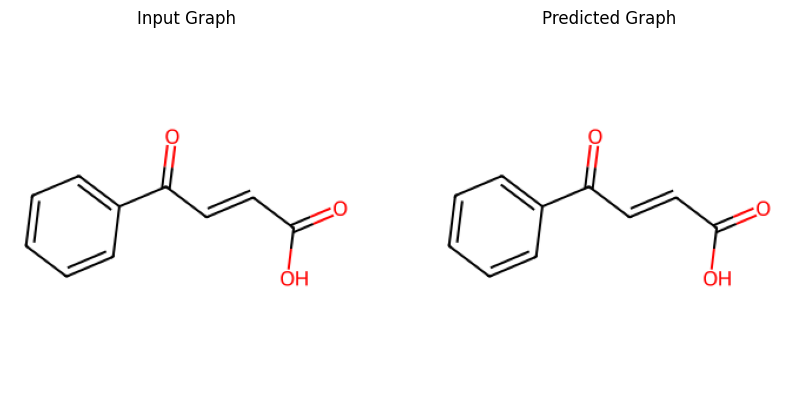

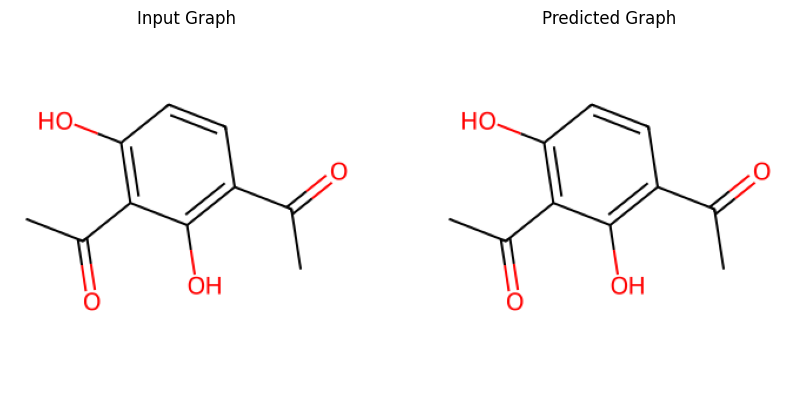

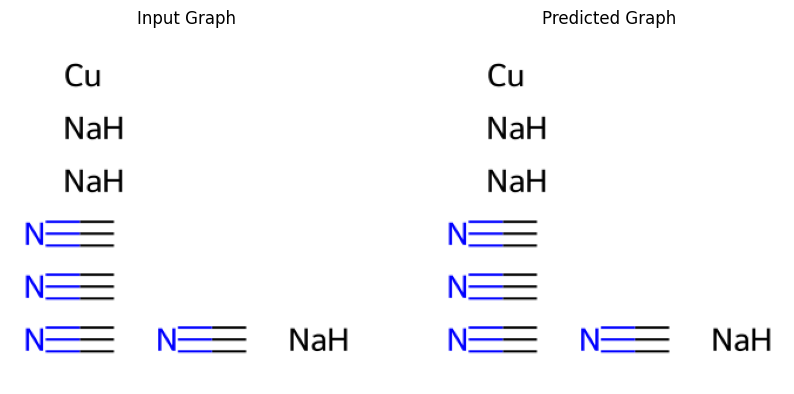

In [ ]:
from GRALE.vizualization.plots import graph_to_rdkit
from rdkit.Chem import Draw

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)

        if smiles_inputs is None or smiles_targets is None:
            continue
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            img1 = Draw.MolToImage(mol_inputs, size=(300, 300))
            img2 = Draw.MolToImage(mol_targets, size=(300, 300))
            ax1.imshow(img1)
            ax1.set_title("Input Graph")
            ax1.axis('off')
            ax2.imshow(img2)
            ax2.set_title("Predicted Graph")
            ax2.axis('off')
            plt.show()
    break

In [ ]:
from GRALE.vizualization.plots import graph_to_rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

loader_val = datamodule.val_dataloader()
n_total = 0
n_valid_inputs = 0
n_exact_recons = 0
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)
        
        n_total += 1
        if smiles_inputs is None:
            pass
        else:
            n_valid_inputs += 1
            if smiles_inputs == smiles_targets:
                n_exact_recons += 1

print(f"Exact match: {n_exact_recons}/{n_valid_inputs} = {n_exact_recons/n_valid_inputs:.2%}")
print(f"Valid inputs: {n_valid_inputs}/{n_total} = {n_valid_inputs/n_total:.2%}")



Exact match: 7462/8691 = 85.86%
Valid inputs: 8691/10000 = 86.91%


# Graph interpolation in the latent space

In [15]:
from GRALE.vizualization.interpolation import interpolate, get_matrices, interpolate_pos_with_none, plot_graph_interpolation, get_pos_with_none

dataset = datamodule.dataset_valid
idx_start = 0
idx_end = 2
n_timesteps = 128

# Get start and end graphs and interpolate
start = dataset[idx_start]
end = dataset[idx_end]
predictions = interpolate(start, end, model, device ='cuda', n_timesteps=n_timesteps)
# Main trick: the model reconstruction produced graphs that are ordered consistently
start = predictions[0] 
end = predictions[-1]
# Get the positions for the plots
h_start, F_start, A_start = get_matrices(start)
pos_start = get_pos_with_none(h_start, A_start)
h_end, F_end, A_end = get_matrices(end)
pos_end = get_pos_with_none(h_end, A_end)


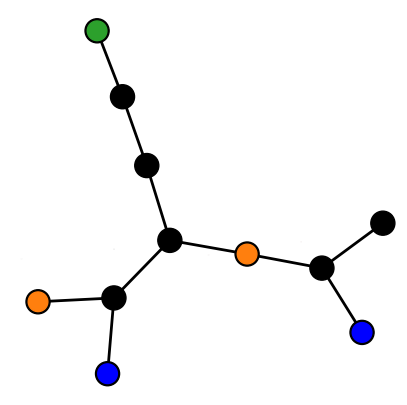

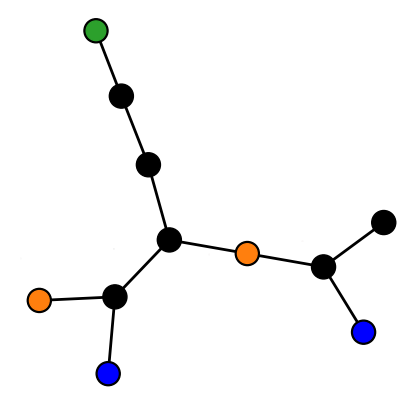

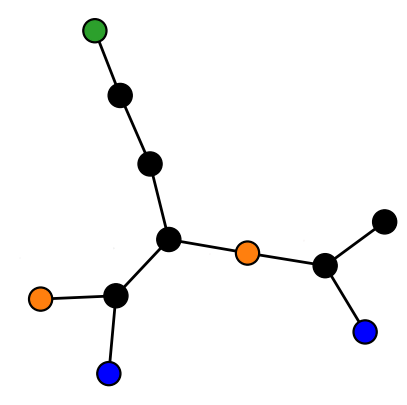

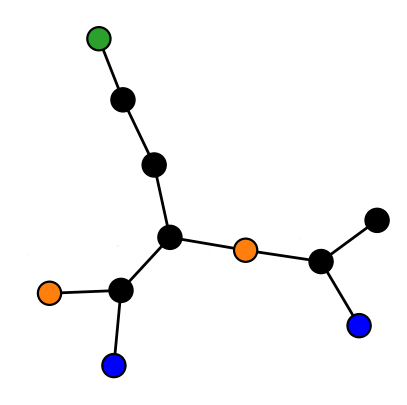

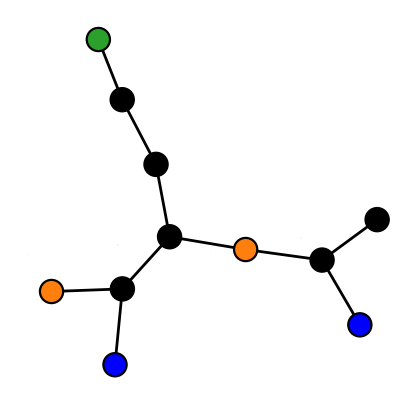

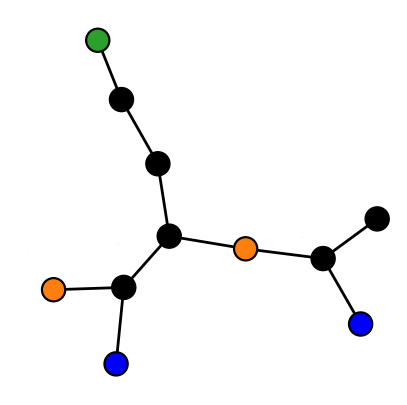

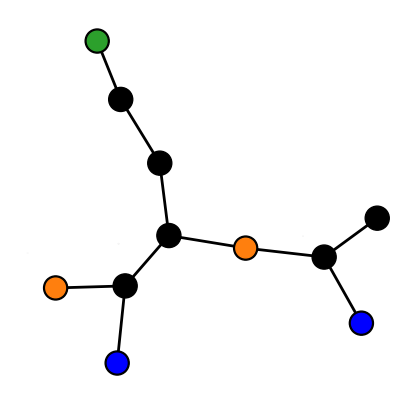

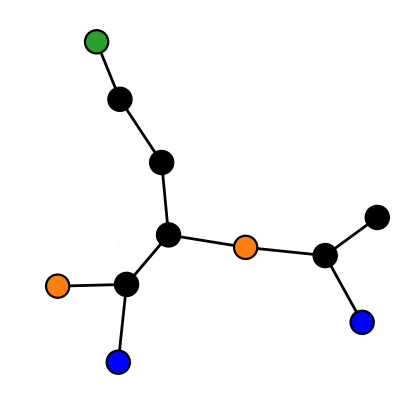

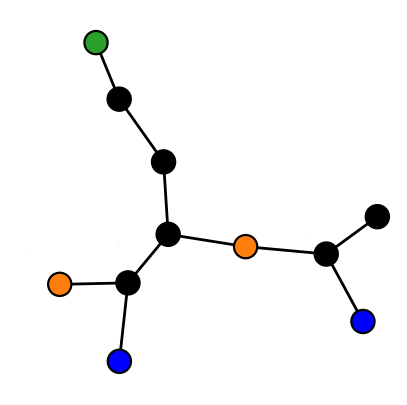

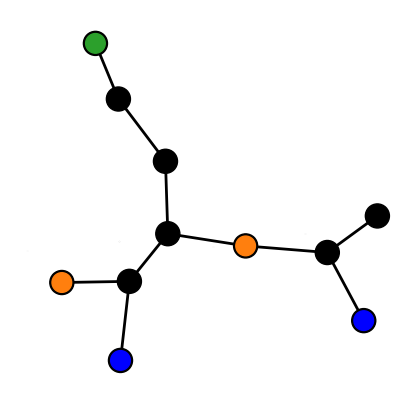

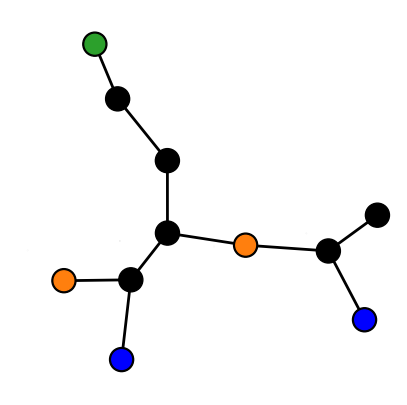

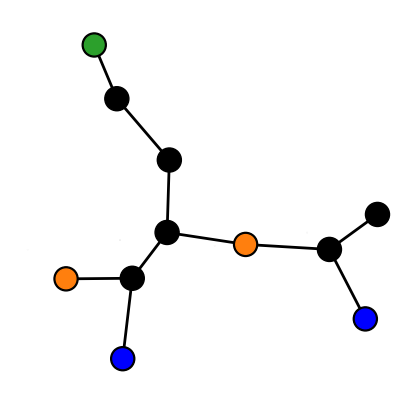

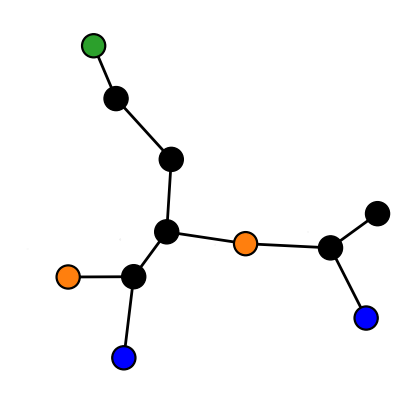

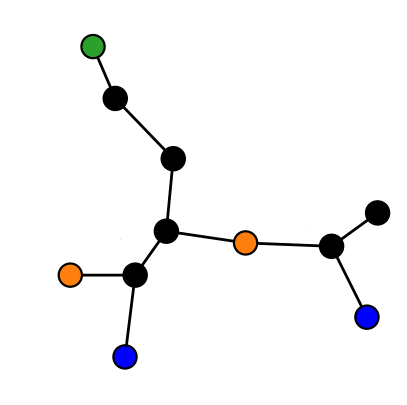

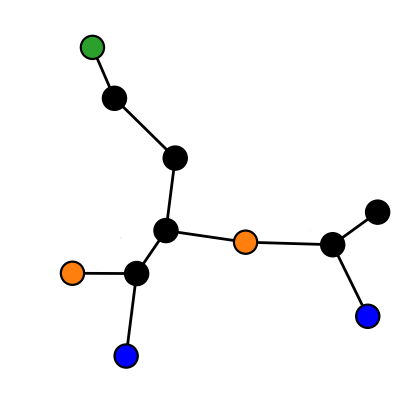

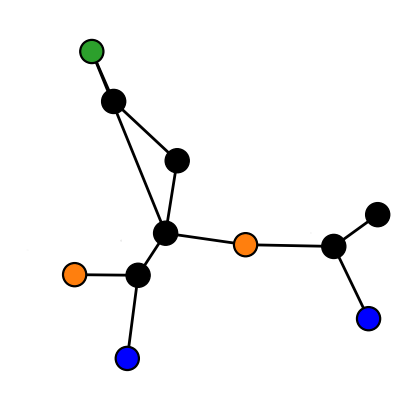

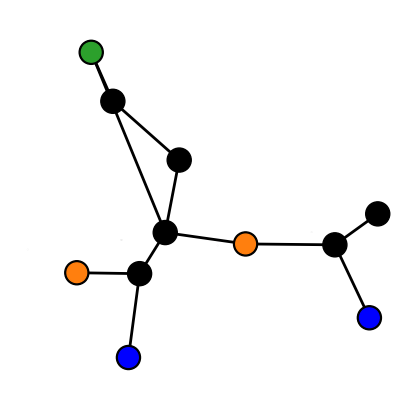

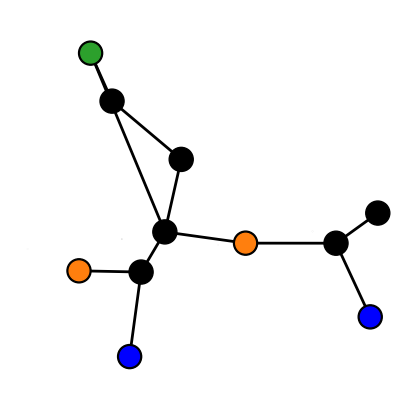

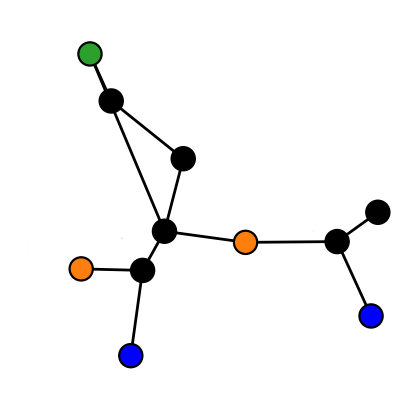

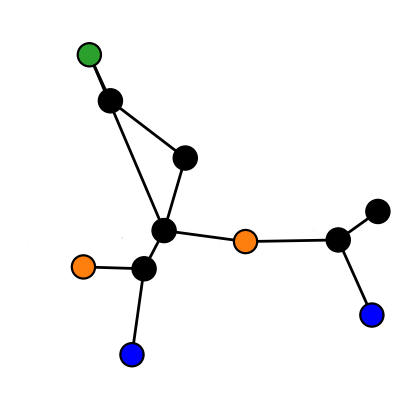

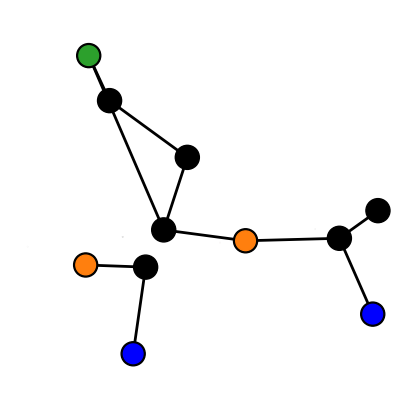

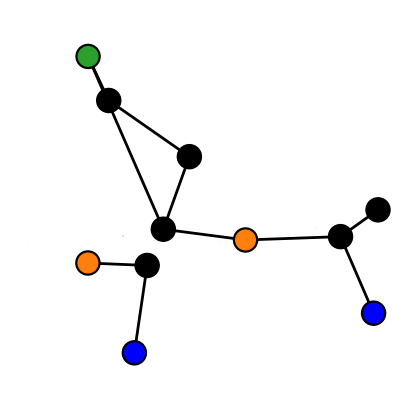

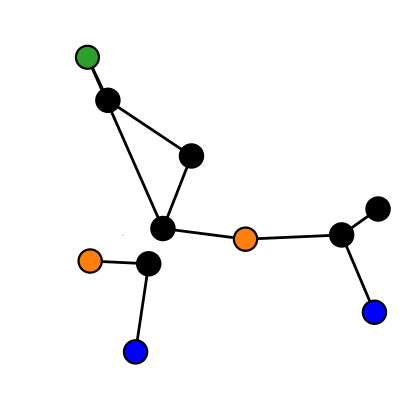

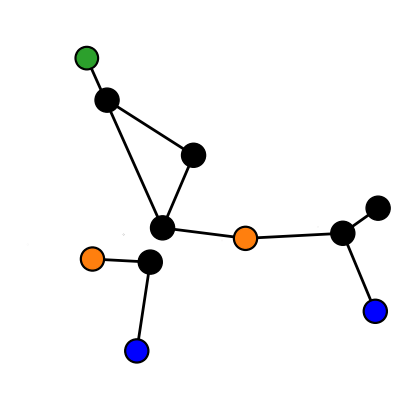

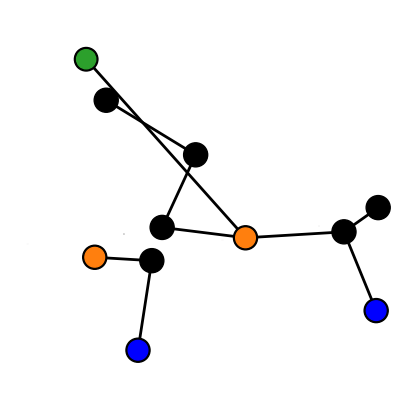

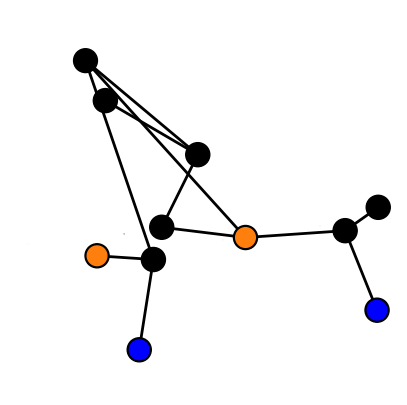

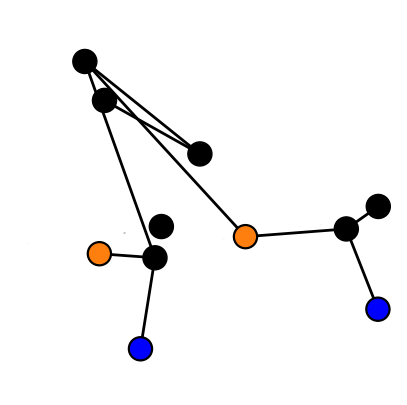

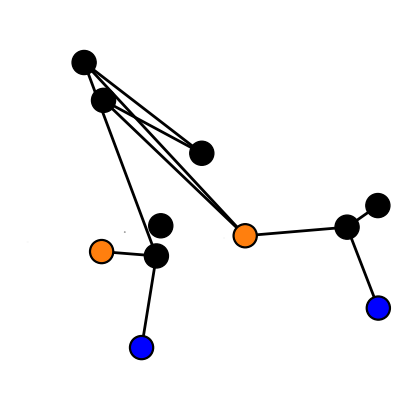

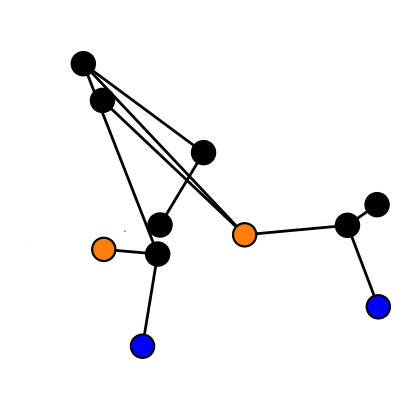

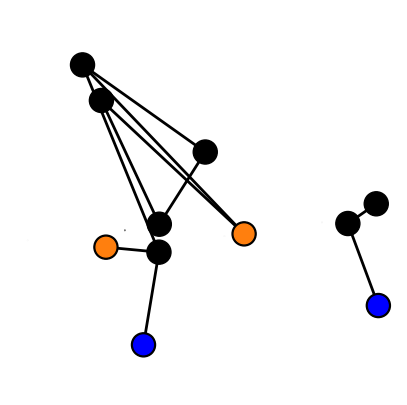

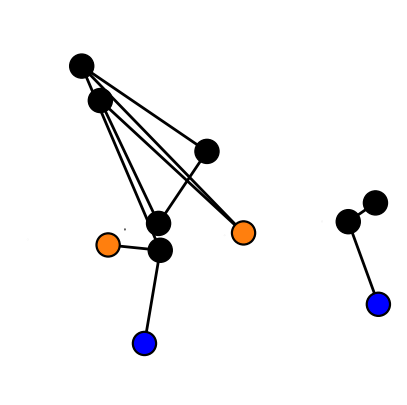

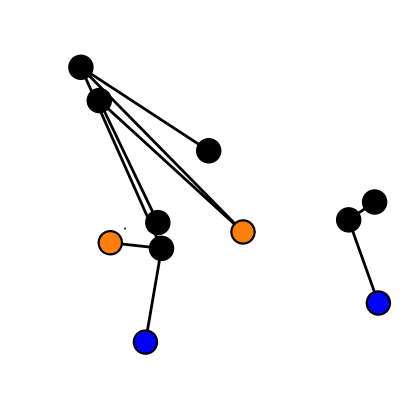

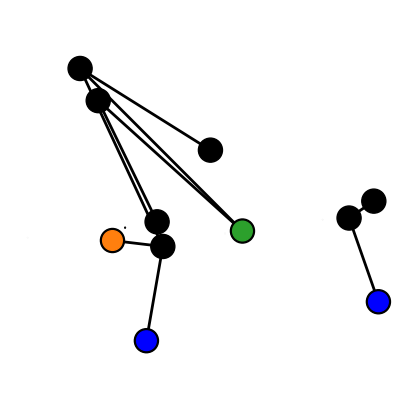

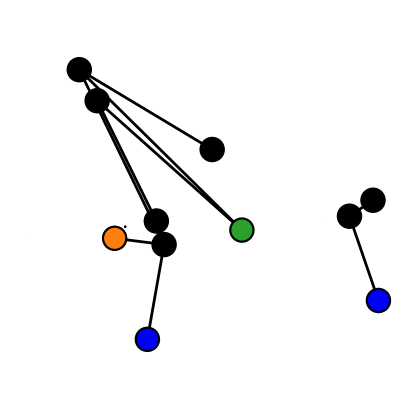

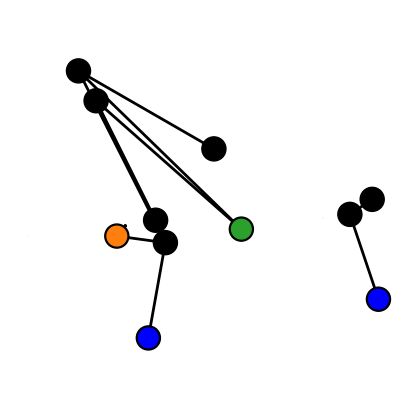

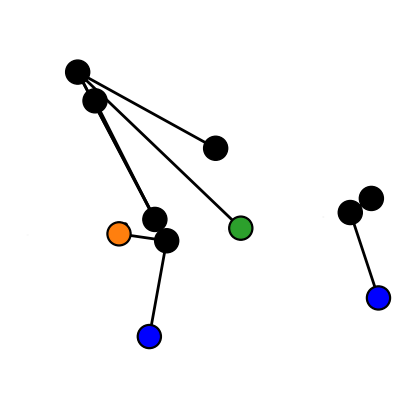

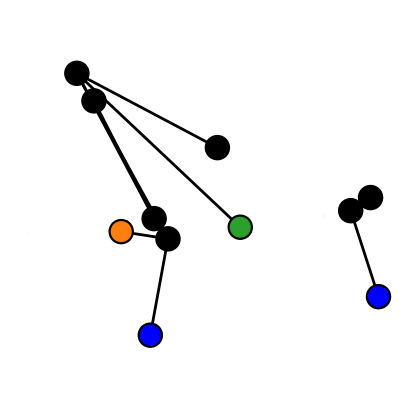

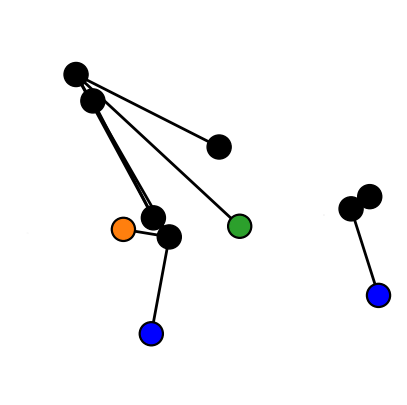

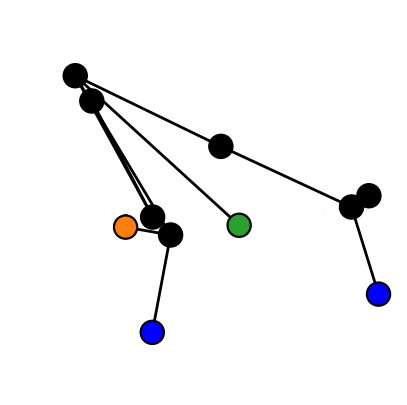

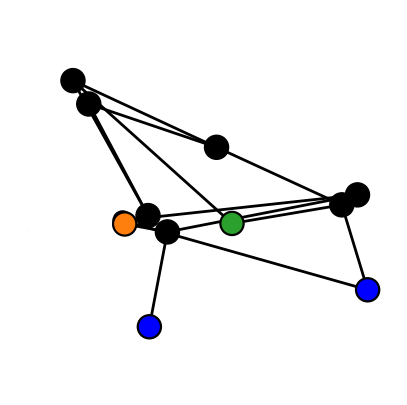

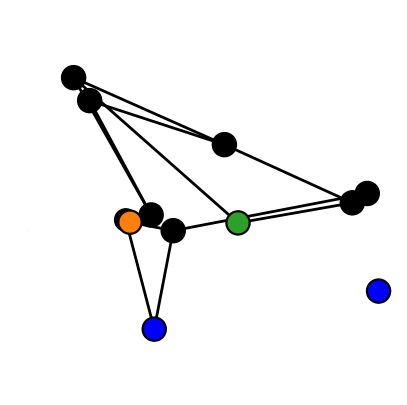

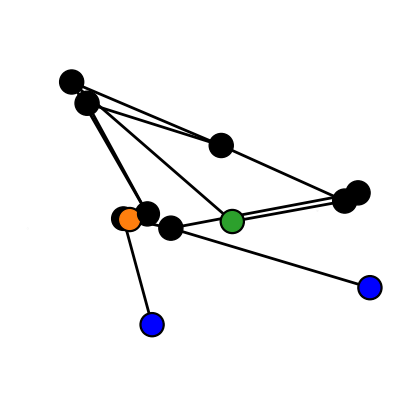

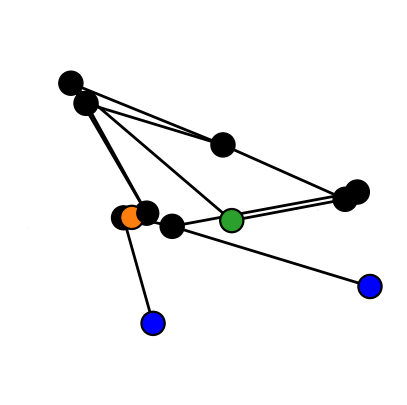

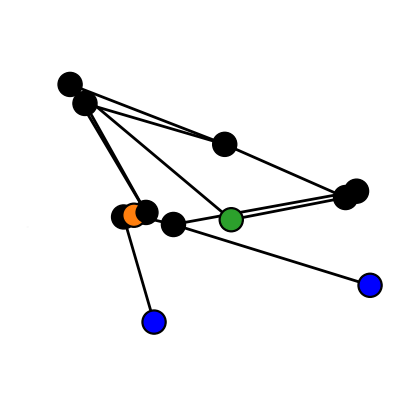

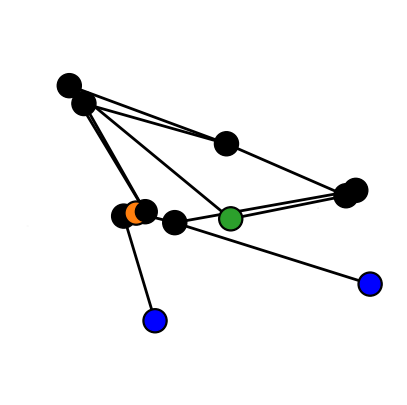

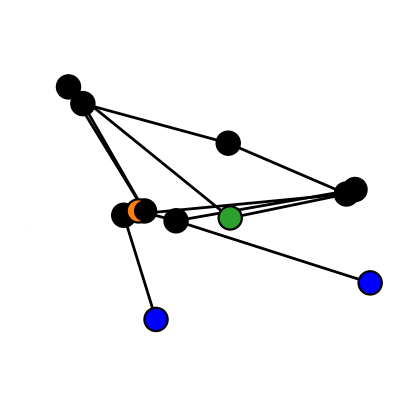

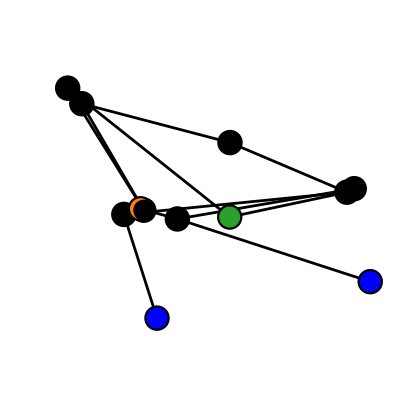

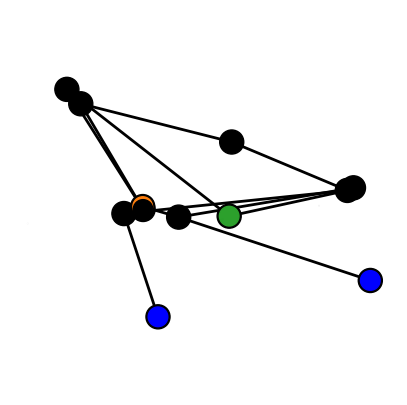

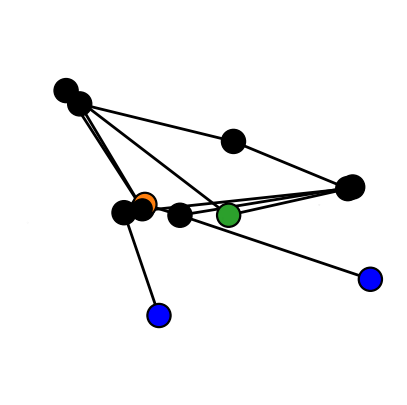

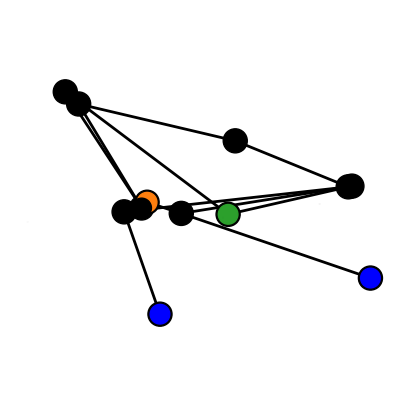

In [17]:
import matplotlib.pyplot as plt
for t in range(50):
    graph_t = predictions[t]
    h, F, A = get_matrices(graph_t)
    pos = interpolate_pos_with_none(pos_start, pos_end, t/(n_timesteps-1))
    plt.figure(figsize=(5,5))
    plot_graph_interpolation(pos,h,F,A,ax=None,frame=False,edge_weight=False, node_size=200)
    plt.show()